# Описание проекта

Интернет-магазин «Викишоп» запускает новый сервис. Теперь пользователи могут редактировать и дополнять описания товаров, как в вики-сообществах. То есть клиенты предлагают свои правки и комментируют изменения других. Магазину нужен инструмент, который будет искать токсичные комментарии и отправлять их на модерацию. 

Наша задача заключается в создании модели, которая будет классифицировать комментарии на позитивные и негативные. 

Итоговая метрика качества F1 должна быть не меньше 0.75.

In [1]:
import pandas as pd
import re
import nltk
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.metrics import (
    f1_score,
    confusion_matrix,
    ConfusionMatrixDisplay
)
from sklearn.pipeline import make_pipeline
from sklearn.feature_extraction.text import (
    CountVectorizer,
    TfidfVectorizer
)
import time
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from catboost import (
    CatBoostClassifier,
    Pool
)
from lightgbm import LGBMClassifier
from IPython import display
from nltk.corpus import wordnet
import torch
from concurrent.futures import ThreadPoolExecutor
from sklearn.pipeline import Pipeline
import transformers
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')
nltk.download('omw-1.4')
from tqdm.notebook import tqdm
RANDOM_STATE = 42

import warnings
warnings.filterwarnings('ignore')

[nltk_data] Downloading package punkt to /home/jovyan/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /home/jovyan/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package wordnet to /home/jovyan/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /home/jovyan/nltk_data...


# Загрузка данных

In [2]:
try:
    toxic_comments = pd.read_csv('toxic_comments.csv', index_col='Unnamed: 0')
except:
    toxic_comments = pd.read_csv('/datasets/toxic_comments.csv', index='Unnamed: 0')
toxic_comments.head(10)

,text,toxic
0,Explanation\nWhy the edits made under my usern...,0
1,D'aww! He matches this background colour I'm s...,0
2,"Hey man, I'm really not trying to edit war. It...",0
3,"""\nMore\nI can't make any real suggestions on ...",0
4,"You, sir, are my hero. Any chance you remember...",0
5,"""\n\nCongratulations from me as well, use the ...",0
6,COCKSUCKER BEFORE YOU PISS AROUND ON MY WORK,1
7,Your vandalism to the Matt Shirvington article...,0
8,Sorry if the word 'nonsense' was offensive to ...,0
9,alignment on this subject and which are contra...,0


In [3]:
toxic_comments.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 159292 entries, 0 to 159450
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   text    159292 non-null  object
 1   toxic   159292 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 3.6+ MB


## Вывод 

Данные были предзагружены. Проблем при загрузке не возникло. Пропуски в данных отсутсвуют.

# Предобработка данных

Нужно убрать из текста символы не принадлежащие английскому алфавиту, привести буквы к нижнему регистру, токенизировать и лемматизировать слова. Сделаем это один раз, затем, чтобы не ждать каждый раз, брать данные из файла.

In [4]:
try:
    df = pd.read_csv('lemmatized_toxic_comments.csv', sep='\t')
except:
    tqdm.pandas()
    
    df = toxic_comments.copy()
    lemmatize = nltk.WordNetLemmatizer()
    
    def get_wordnet_pos(word):
        """Map POS tag to first character lemmatize() accepts"""
        tag = nltk.pos_tag([word])[0][1][0].upper()
        tag_dict = {"J": wordnet.ADJ,
                    "N": wordnet.NOUN,
                    "V": wordnet.VERB,
                    "R": wordnet.ADV}
        return tag_dict.get(tag, wordnet.NOUN)
    
    def clean(row):
        text = re.sub(r'[^a-zA-Z\']', ' ', row).lower()
        text = nltk.word_tokenize(text)
        text = [lemmatize.lemmatize(word, get_wordnet_pos(word)) for word in text]
        row = ' '.join(text)
    
        return row
    
    start = time.time()
    df['lemmatized_text'] = df['text'].progress_apply(clean)
    end = time.time()

    df['length'] = df['lemmatized_text'].apply(lambda x: len(x))

    
    df.to_csv('lemmatized_toxic_comments.csv', sep='\t')
    print('Время лемматизации:', end-start)

  0%|          | 0/159292 [00:00<?, ?it/s]

Время лемматизации: 1286.1137211322784


Посмотрим характеристики датасета, но перед этим удалим комментарии с нулевой длиной.

In [5]:
df = df[df['length']!=0]

print('Длина датасета:', len(df))
print('Длина самого короткого текста:', min(df['length']))
print('Длина самого длинного текста:', max(df['length']))
print('Средняя длина текста:', np.mean(df['length']))
print('Медианная длина текста:', np.median(df['length']))
print('Количество обычных комментариев:', len(df[df['toxic']==0]))
print('Количество токсичных комментариев:', len(df[df['toxic']==1]))

Длина датасета: 159282
Длина самого короткого текста: 2
Длина самого длинного текста: 5000
Средняя длина текста: 360.33609572958653
Медианная длина текста: 187.0
Количество обычных комментариев: 143097
Количество токсичных комментариев: 16185


Как видим, комментарии имеются разные. Их длина разнится от 2 до 5000. Средняя длина комментария - 360, а медианная - 187. Количество обычных комментариев в 10 раз превышает количество обычных комментариев, это нужно будет учесть при разделении на выборки.

Поделим данные на тестовую, тренировочную и валидациоонную выборки.

In [6]:
X = df['lemmatized_text']
y = df['toxic']

X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.1,
    random_state=RANDOM_STATE,
    stratify=y
)

X_train, X_val, y_train, y_val = train_test_split(
    X_train,
    y_train,
    test_size=0.1,
    random_state=RANDOM_STATE,
    stratify=y_train
)

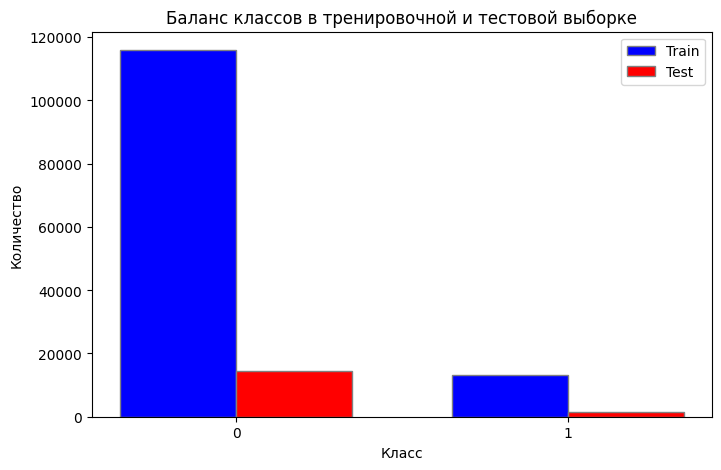

In [7]:
train_counts = y_train.value_counts()
test_counts = y_test.value_counts()

classes = np.union1d(train_counts.index, test_counts.index)

train_counts = train_counts.reindex(classes, fill_value=0)
test_counts = test_counts.reindex(classes, fill_value=0)

bar_width = 0.35
r1 = np.arange(len(classes))
r2 = [x + bar_width for x in r1]

plt.figure(figsize=(8, 5))

plt.bar(r1, train_counts, color='b', width=bar_width, edgecolor='grey', label='Train')
plt.bar(r2, test_counts, color='r', width=bar_width, edgecolor='grey', label='Test')

plt.xlabel('Класс')
plt.ylabel('Количество')
plt.title('Баланс классов в тренировочной и тестовой выборке')
plt.xticks([r + bar_width / 2 for r in range(len(classes))], classes)
plt.legend()

plt.show()

Классы в выборках имеют похожее распределение. В классах имеется сильный дисбаланс, будем в моделях сообщать об этом.

## Вывод

Данные были предобработаны, создана копия датафрейма. Были удалены все символы, кроме символов английского алфавита, из текста и приведены к нижнему регистру. Был добавлен столбец с длинной каждогой текста, вот данные по датасету:

Длина датасета: 159281
Длина самого короткого текста: 2
Длина самого длинного текста: 5000
Средняя длина текста: 367.1779119920141
Медианная длина текста: 190.0
Количество обычных комментариев: 143096
Количество токсичных комментариев: 16185

Данные были разделены тренировочную, валидационную и тестовую выборки.

# Обучение моделей

Создадим класс, экземпляры которого будут хранить модель, способ векторизации и функцию метрики.

In [8]:
class WorkFlow():

    def __init__(self, model, vectorizer=None, scoring=f1_score):
        if vectorizer:
            self.model = make_pipeline(vectorizer, model)
        self.score_func = scoring

    def fit(self, X, y):
        start = time.time()
        self.model.fit(X,y)
        end = time.time()
        self.fitting_time = end - start 
    
    def predict(self, X):
        return self.model.predict(X)

    def count_metric(self, X, y, name='тренировочной'):
        metric = self.score_func(y, self.predict(X))
        time_fit = self.fitting_time 
        
        cm = confusion_matrix(y, self.predict(X))
        
        disp = ConfusionMatrixDisplay(confusion_matrix=cm)
        disp.plot(cmap=plt.cm.Blues)
        plt.title(f'Матрица ошибок {name} выборки')
        plt.show()

        return metric

    def get_time(self):
        return self.fitting_time

Посмотрим модели, будем использовать логистическую регрессию, CatBoost и LightGBM. У CatBoost и LightGBM имеются встроенные методы работы с дисбалансом. Логистической регрессии будем передавать веса классов, посчитаем по формуле ниже.

In [9]:
class_ratio = df['toxic'].value_counts()[0] / df['toxic'].value_counts()[1]
print('Соотношение классов:', class_ratio)
weight_classes = {0:1, 1:class_ratio} 

bow = CountVectorizer(stop_words='english', dtype=np.float32)
tfidf = TfidfVectorizer(stop_words='english', dtype=np.float32)

Соотношение классов: 8.841334569045413


## Логистическая регрессия

Результат BOW


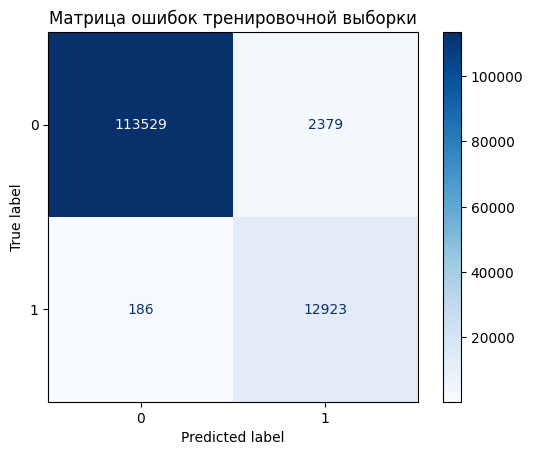

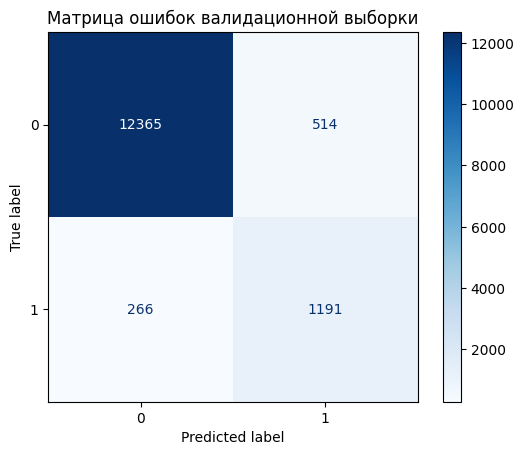

Метрика на тренировочной выборке: 0.9097180669459012
Метрика на валидационной выборке: 0.7533206831119544
Время обучения: 49.54402208328247


In [10]:
logistic_bow = WorkFlow(LogisticRegression(max_iter=1000, class_weight=weight_classes, random_state=RANDOM_STATE), vectorizer=bow)
print('Результат BOW')
logistic_bow.fit(X_train, y_train)
logistic_bow_metric_train = logistic_bow.count_metric(X_train, y_train, name='тренировочной')
logistic_bow_metric_val = logistic_bow.count_metric(X_val, y_val, name='валидационной')
logistic_bow_fit_time = logistic_bow.get_time()

print('Метрика на тренировочной выборке:', logistic_bow_metric_train)
print('Метрика на валидационной выборке:', logistic_bow_metric_val)
print('Время обучения:', logistic_bow_fit_time)

Результат TF-IDF


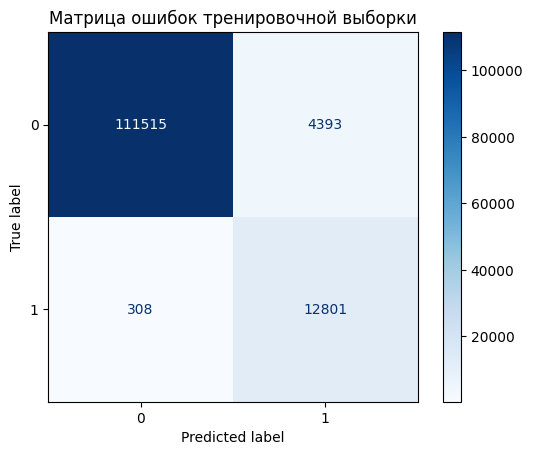

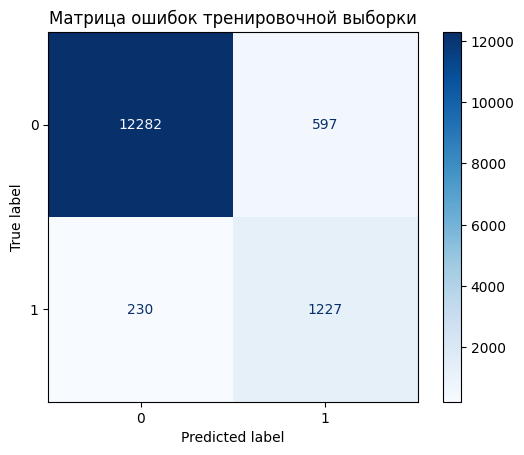

Метрика на тренировочной выборке: 0.8448668448668448
Метрика на валидационной выборке: 0.7479427003962207
Время обучения: 49.54402208328247


In [11]:
logistic_tfidf = WorkFlow(LogisticRegression(max_iter=1000, class_weight=weight_classes, random_state=RANDOM_STATE), vectorizer=tfidf)
print('Результат TF-IDF')
logistic_tfidf.fit(X_train, y_train)
logistic_tfidf_metric_train = logistic_tfidf.count_metric(X_train, y_train)
logistic_tfidf_metric_val = logistic_tfidf.count_metric(X_val, y_val)
logistic_tfidf_fit_time = logistic_tfidf.get_time()

print('Метрика на тренировочной выборке:', logistic_tfidf_metric_train)
print('Метрика на валидационной выборке:', logistic_tfidf_metric_val)
print('Время обучения:', logistic_bow_fit_time)

Как видим, метрика на валидационной выборке получилась подходящей. 

## CatBoost

Поставим auto_class_weights равным Balanced, чтобы учесть дисбаланс классов.

Результат BOW


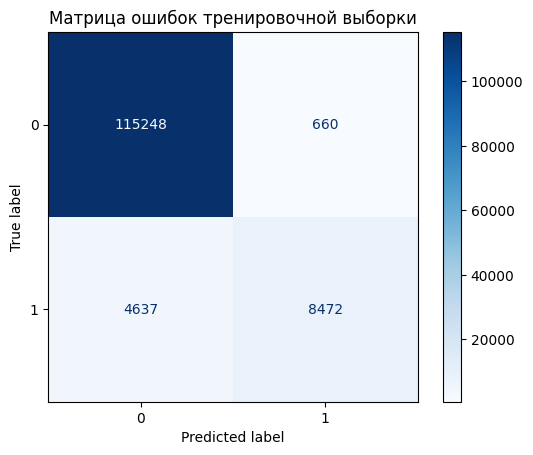

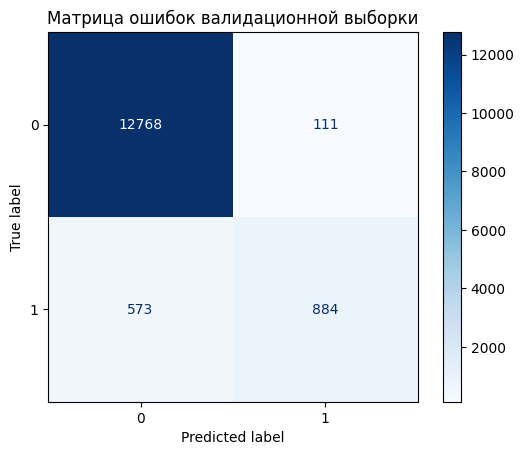

Метрика на тренировочной выборке: 0.7618362483701272
Метрика на валидационной выборке: 0.7210440456769984
Время обучения: 193.28839921951294


In [12]:
catboost_bow = WorkFlow(CatBoostClassifier(iterations=250, verbose=False, random_state=RANDOM_STATE), vectorizer=bow)
print('Результат BOW')
catboost_bow.fit(X_train, y_train)
catboost_bow_metric_train = catboost_bow.count_metric(X_train, y_train, name='тренировочной')
catboost_bow_metric_val = catboost_bow.count_metric(X_val, y_val, name='валидационной')
catboost_bow_fit_time = catboost_bow.get_time()

print('Метрика на тренировочной выборке:', catboost_bow_metric_train)
print('Метрика на валидационной выборке:', catboost_bow_metric_val)
print('Время обучения:', catboost_bow_fit_time)

Результат TF-IDF


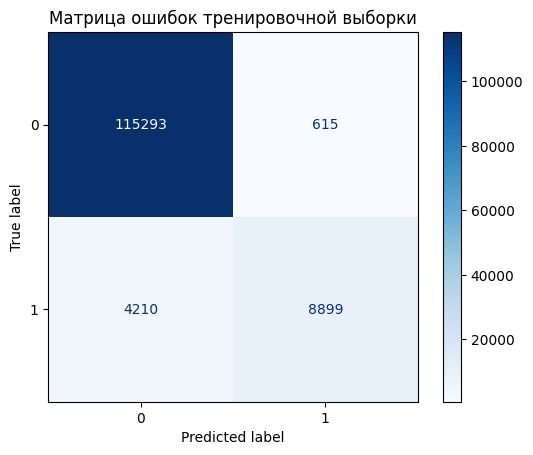

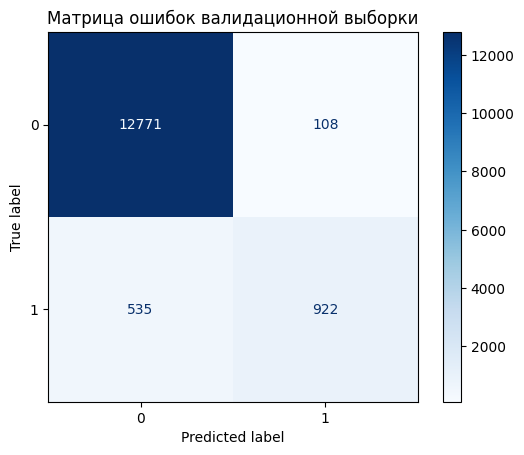

Метрика на тренировочной выборке: 0.7867214781417142
Метрика на валидационной выборке: 0.7414555689585847
Время обучения: 359.94463872909546


In [13]:
catboost_tfidf = WorkFlow(CatBoostClassifier(iterations=250, verbose=False, random_state=RANDOM_STATE), vectorizer=tfidf)
print('Результат TF-IDF')
catboost_tfidf.fit(X_train, y_train)
catboost_tfidf_metric_train = catboost_tfidf.count_metric(X_train, y_train, name='тренировочной')
catboost_tfidf_metric_val = catboost_tfidf.count_metric(X_val, y_val, name='валидационной')
catboost_tfidf_fit_time = catboost_tfidf.get_time()

print('Метрика на тренировочной выборке:', catboost_tfidf_metric_train)
print('Метрика на валидационной выборке:', catboost_tfidf_metric_val)
print('Время обучения:', catboost_tfidf_fit_time)

Попробуем использовать CatBoost для классификации текстов.

In [14]:
learn_pool = Pool(
    X_train.reset_index(), 
    y_train.reset_index()['toxic'], 
    cat_features=[],
    text_features=['lemmatized_text'],
)
val_pool = Pool(
    X_val.reset_index(), 
    y_val.reset_index()['toxic'], 
    cat_features=[],
    text_features=['lemmatized_text'],
)

catboost_default_params = {
    'iterations': 1000,
    'learning_rate': 0.03,
    'eval_metric': 'F1',
}
catboost_default_params.update()

model_catboost_integr = CatBoostClassifier(**catboost_default_params, random_state=RANDOM_STATE)
start = time.time()
model_catboost_integr.fit(learn_pool, eval_set=val_pool, verbose=True)
end=time.time()
catboost_integr_fit_time = end - start

0:	learn: 0.7180428	test: 0.7410992	best: 0.7410992 (0)	total: 110ms	remaining: 1m 49s
1:	learn: 0.7029349	test: 0.7325622	best: 0.7410992 (0)	total: 225ms	remaining: 1m 52s
2:	learn: 0.7070449	test: 0.7376870	best: 0.7410992 (0)	total: 354ms	remaining: 1m 57s
3:	learn: 0.7154712	test: 0.7407678	best: 0.7410992 (0)	total: 470ms	remaining: 1m 57s
4:	learn: 0.7184545	test: 0.7445887	best: 0.7445887 (4)	total: 589ms	remaining: 1m 57s
5:	learn: 0.7183064	test: 0.7443202	best: 0.7445887 (4)	total: 708ms	remaining: 1m 57s
6:	learn: 0.7183064	test: 0.7443202	best: 0.7445887 (4)	total: 846ms	remaining: 1m 59s
7:	learn: 0.7184008	test: 0.7449422	best: 0.7449422 (7)	total: 972ms	remaining: 2m
8:	learn: 0.7185230	test: 0.7443202	best: 0.7449422 (7)	total: 1.12s	remaining: 2m 3s
9:	learn: 0.7160675	test: 0.7432090	best: 0.7449422 (7)	total: 1.25s	remaining: 2m 3s
10:	learn: 0.7184387	test: 0.7435805	best: 0.7449422 (7)	total: 1.4s	remaining: 2m 5s
11:	learn: 0.7097914	test: 0.7383382	best: 0.74494

In [15]:
print("Результат встроенного обработчика CatBoost")

catboost_integr_metric_train = f1_score(y_train, model_catboost_integr.predict(learn_pool))
catboost_integr_metric_val = f1_score(y_val, model_catboost_integr.predict(val_pool))

print('Метрика на тренировочной выборке:', catboost_integr_metric_train)
print('Метрика на валидационной выборке:', catboost_integr_metric_val)
print('Время обучения:', catboost_integr_fit_time)

Результат встроенного обработчика CatBoost
Метрика на тренировочной выборке: 0.8244698475811796
Метрика на валидационной выборке: 0.7930250189537529
Время обучения: 136.04444313049316


Как видим, лучше всего вышел встроенный предобработчик CatBoost.

## LightGBM

Результат TF-IDF
[LightGBM] [Info] Number of positive: 13109, number of negative: 115908
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 1.941790 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 44294
[LightGBM] [Info] Number of data points in the train set: 129017, number of used features: 9849
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000


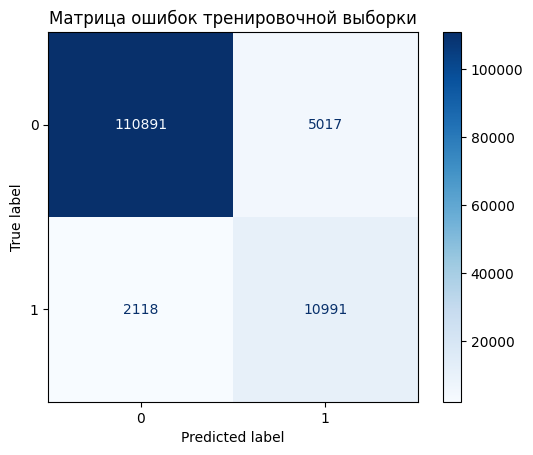

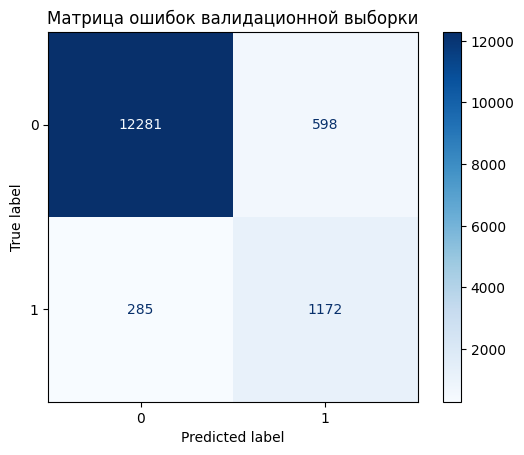

Метрика на тренировочной выборке: 0.7549541504962737
Метрика на валидационной выборке: 0.7263712426402231
Время обучения: 12.441380977630615


In [16]:
light_bow = WorkFlow(LGBMClassifier(class_weight ='balanced', random_state=RANDOM_STATE), vectorizer=bow)
print('Результат TF-IDF')
light_bow.fit(X_train, y_train)
light_bow_metric_train = light_bow.count_metric(X_train, y_train, name='тренировочной')
light_bow_metric_val = light_bow.count_metric(X_val, y_val, name='валидационной')
light_bow_fit_time = light_bow.get_time()

print('Метрика на тренировочной выборке:', light_bow_metric_train)
print('Метрика на валидационной выборке:', light_bow_metric_val)
print('Время обучения:', light_bow_fit_time)

Результат TF-IDF
[LightGBM] [Info] Number of positive: 13109, number of negative: 115908
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 1.886525 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 521208
[LightGBM] [Info] Number of data points in the train set: 129017, number of used features: 9849
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000


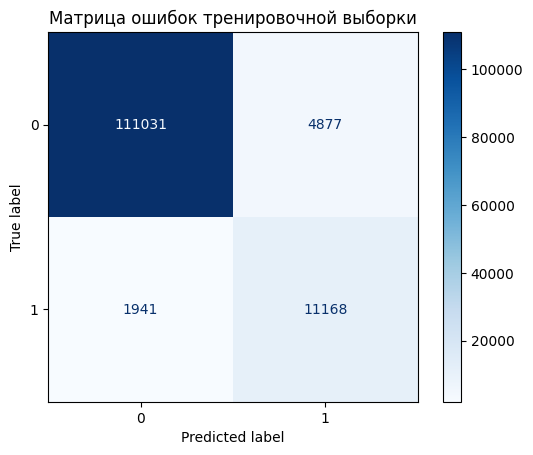

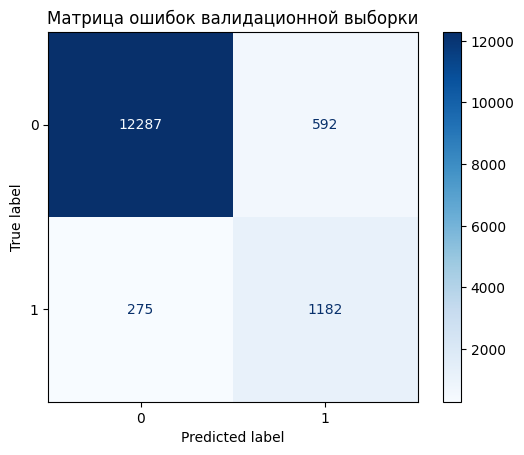

Метрика на тренировочной выборке: 0.7661384372641833
Метрика на валидационной выборке: 0.7316620241411328
Время обучения: 25.405032873153687


In [17]:
light_tfidf = WorkFlow(LGBMClassifier(class_weight ='balanced', random_state=RANDOM_STATE), vectorizer=tfidf)
print('Результат TF-IDF')
light_tfidf.fit(X_train, y_train)
light_tfidf_metric_train = light_tfidf.count_metric(X_train, y_train, name='тренировочной')
light_tfidf_metric_val = light_tfidf.count_metric(X_val, y_val, name='валидационной')
light_tfidf_fit_time = light_tfidf.get_time()

print('Метрика на тренировочной выборке:', light_tfidf_metric_train)
print('Метрика на валидационной выборке:', light_tfidf_metric_val)
print('Время обучения:', light_tfidf_fit_time)

## Вывод 

Модели были обучены. Посмотрим общую таблицу моделей.

In [18]:
ml_results = pd.DataFrame([
    ['Линейная регрессия BOW', logistic_bow_metric_train, logistic_bow_metric_val, logistic_bow_fit_time],
    ['Линейная регрессия TF-IDF', logistic_tfidf_metric_train, logistic_tfidf_metric_val, logistic_tfidf_fit_time],
    ['CatBoost BOW', catboost_bow_metric_train, catboost_bow_metric_val, catboost_bow_fit_time],
    ['CatBoost TF-IDF', catboost_tfidf_metric_train, catboost_tfidf_metric_val, catboost_tfidf_fit_time],
    ['CatBoost Integrated', catboost_integr_metric_train, catboost_integr_metric_val, catboost_integr_fit_time],
    ['LigthGBM BOW', light_bow_metric_train, light_bow_metric_val, light_bow_fit_time],
    ['LigthGBM TF-IDF', light_tfidf_metric_train, light_tfidf_metric_val, light_tfidf_fit_time]
],
columns = ['Модель', 'F1 на тренировочной', 'F1 на валидационной', 'Время обучения'])
ml_results

,Модель,F1 на тренировочной,F1 на валидационной,Время обучения
0,Линейная регрессия BOW,0.909718,0.753321,49.544022
1,Линейная регрессия TF-IDF,0.844867,0.747943,12.473671
2,CatBoost BOW,0.761836,0.721044,193.288399
3,CatBoost TF-IDF,0.786721,0.741456,359.944639
4,CatBoost Integrated,0.824470,0.793025,136.044443
5,LigthGBM BOW,0.754954,0.726371,12.441381
6,LigthGBM TF-IDF,0.766138,0.731662,25.405033


Лучшей моделью на валидации вышла CatBoost Integrated, попробуем посчитать на ней тестовую метрику.

In [19]:
test_pool = Pool(
    X_test.reset_index(), 
    y_test.reset_index()['toxic'], 
    cat_features=[],
    text_features=['lemmatized_text'],
)

catboost_integr_metric_test = f1_score(y_test, model_catboost_integr.predict(test_pool))

print('Метрика на тестовой выборке:', catboost_integr_metric_test)
print('Время обучения:', catboost_integr_fit_time)

Метрика на тестовой выборке: 0.7782312925170068
Время обучения: 136.04444313049316


Нужная метрика получена на встроенном предобработчике текста от CatBoost.

# Обучение BERT

Попробуем использовать библиотеку BERT от Google для классификации текста. Для нее нужно использовать видеокартку, поэтому выведем информацю о ней.

In [20]:
print('Доступна ли CUDA:', torch.cuda.is_available())

Доступна ли CUDA: True


Будем использовать уже натренированную модель toxic-bert, которой мы предобработаем данные, затем обучим классическую модель логистической регрессии. Нужно удалить все тексты длинее, чем 512 симвлов, так как модель не сможет столько принять.

Предобработаем данные, сделаем так же загрузку из файла, чтобы не ждать.

In [21]:
try:
    embeddings = np.load('embeddings.npy')
except:
    model_name = "unitary/toxic-bert"
    
    model_trans = transformers.AutoModel.from_pretrained(model_name)
    tokenizer = transformers.AutoTokenizer.from_pretrained(model_name)
    
    text = list(df['text'])
    
    tokenized = tokenizer(text, return_tensors='pt', padding=True, truncation=True, max_length=512)
        
    torch.cuda.empty_cache()
    start = time.time()
    embeddings = []
    torch.cuda.empty_cache()
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model_trans.to(device)
    
    batch_size = 50
    for i in tqdm(range(tokenized['input_ids'].shape[0] // batch_size)):
        
        tokens = tokenized['input_ids'][batch_size*i:batch_size*(i+1)]
        token_types = tokenized['token_type_ids'][batch_size*i:batch_size*(i+1)]
        mask = tokenized['attention_mask'][batch_size*i:batch_size*(i+1)]
    
        batch = {'input_ids' : tokens.to(device),
                 'token_type_ids' : token_types.to(device), 
                 'attention_mask' : mask.to(device)
                }
        with torch.no_grad():
            batch_embeddings = model_trans(**batch)
    
        embeddings.append(batch_embeddings[0][:,0,:].to('cpu').numpy())
    
    embeddings = np.concatenate(embeddings, axis=0)
    np.save('embeddings.npy', embeddings)
    end = time.time()
    torch.cuda.empty_cache()
    
    print('Время получения эмбеддингов:', end-start)

Разделим данные на тренировочную и тестовую выборки.

In [22]:
X_bert = embeddings
y_bert = df['toxic'][0:len(X_bert)]

X_train_bert, X_test_bert, y_train_bert, y_test_bert = train_test_split(X_bert, y_bert, random_state=RANDOM_STATE, stratify=y_bert)

Обучим модель линейной регрессии на получившихся данных.

In [23]:
model_bert = LogisticRegression(random_state=RANDOM_STATE, n_jobs=-1)

model_bert.fit(X_train_bert, y_train_bert)
print('F1 на BERT модели тренировочной выборки:', f1_score(y_train_bert, model_bert.predict(X_train_bert)))
print('F1 на BERT модели тестовой выборки:', f1_score(y_test_bert, model_bert.predict(X_test_bert)))

F1 на BERT модели тренировочной выборки: 0.9556361837222727
F1 на BERT модели тестовой выборки: 0.9428076256499134


Данная модель вышла сильно лучше, чем предыдущие модели. Метрика >0.9, что очень высоко. 

# Вывод

Интернет-магазин «Викишоп» запускает новый сервис, позволяющий пользователям редактировать и дополнять описания товаров, как в вики-сообществах. Для обеспечения качественной модерации комментариев был разработан инструмент, который классифицирует комментарии на позитивные и негативные с использованием машинного обучения. Проблем при загрузке данных не возникло, пропуски в данных отсутствуют. Данные были очищены от всех символов, кроме английских букв, и приведены к нижнему регистру, а также был добавлен столбец с длиной каждого текста. Датасет содержит 159281 комментарий, длина самого короткого текста составляет 2 символа, самого длинного — 5000 символов, средняя длина текста — 360 символов, медианная длина — 180 символов. Из них 143096 комментариев являются обычными и 16185 — токсичными. Данные были разделены на тренировочную, валидационную и тестовую выборки. CatBoost со встроенным предобработчиком показала приемлемые результаты, однако метрика F1 была на грани приемлемого значения (~0.78). Обучение модели BERT дало значительно лучшие результаты с метрикой F1 > 0.9. Модель BERT продемонстрировала высокую эффективность в классификации комментариев, значительно превышая минимально необходимую метрику F1 в 0.75. 

In [24]:
ml_results

,Модель,F1 на тренировочной,F1 на валидационной,Время обучения
0,Линейная регрессия BOW,0.909718,0.753321,49.544022
1,Линейная регрессия TF-IDF,0.844867,0.747943,12.473671
2,CatBoost BOW,0.761836,0.721044,193.288399
3,CatBoost TF-IDF,0.786721,0.741456,359.944639
4,CatBoost Integrated,0.824470,0.793025,136.044443
5,LigthGBM BOW,0.754954,0.726371,12.441381
6,LigthGBM TF-IDF,0.766138,0.731662,25.405033


In [25]:
print('Результат лучшей модели')
print('Метрика на тестовой выборке:', catboost_integr_metric_test)
print('Время обучения:', catboost_integr_fit_time)

Результат лучшей модели
Метрика на тестовой выборке: 0.7782312925170068
Время обучения: 136.04444313049316


In [26]:
print('F1 на BERT модели тренировочной выборки:', f1_score(y_train_bert, model_bert.predict(X_train_bert)))
print('F1 на BERT модели тестовой выборки:', f1_score(y_test_bert, model_bert.predict(X_test_bert)))

F1 на BERT модели тренировочной выборки: 0.9556361837222727
F1 на BERT модели тестовой выборки: 0.9428076256499134
